<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp3_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 Parte II: Baseline

Del análisis exploratorio de la parte I hemos aprendido algunas cosas:
- Hay algunas columnas que no nos aportan información. En particular *did* tiene utilidad por no estar en la mayoría de columnas. El *artist_name* no debería proporcionar demasiada información al modelo teniendo en cuenta que tenemos su número de canciones y sus géneros predilectos.

- Algunas columnas requieren preprocessing. Las tres columnas de texto que tenemos, *track-name*, *lyrics* y *artist*, no pueden ser usadas directamente. *mode* y *key*, por otro lado, son features categóricas. *a_genres* también es una variable categórica que contiene varias clases. Luego hay que preprocesar las features de texto para crear nuevos features útiles, y preprocesar las features categóricas para poder utilizarlas en la regresión logística.

- No tenemos suficientes observaciones para algunos de los posibles valores del target.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score
from google.colab import drive 
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import functools

drive.mount('/content/gdrive')
path_a_training_set = 'gdrive/MyDrive/TP3 dataset music/train.parquet'
path_a_test_set = 'gdrive/MyDrive/TP3 dataset music/test.parquet'


df_music_train = pd.read_parquet(path_a_training_set)
df_music_test = pd.read_parquet(path_a_test_set)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [152]:
df_music_train_filtered = df_music_train.drop(labels=["did"], axis=1)
df_music_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31383 entries, 0 to 34336
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        31383 non-null  object 
 1   lyric             31380 non-null  object 
 2   genre             31383 non-null  object 
 3   language          24021 non-null  object 
 4   popularity        31383 non-null  int64  
 5   artist            31383 non-null  object 
 6   a_genres          31383 non-null  object 
 7   a_songs           31383 non-null  float64
 8   a_popularity      31383 non-null  float64
 9   s-label           7004 non-null   float64
 10  acousticness      31383 non-null  float64
 11  danceability      31383 non-null  float64
 12  duration_ms       31383 non-null  int64  
 13  energy            31383 non-null  float64
 14  instrumentalness  31383 non-null  float64
 15  key               31383 non-null  object 
 16  liveness          31383 non-null  float6

## Preprocessing

En primer lugar notamos que las variables categóricas *key* y *time-signature* ambas son ordinales. La primera representa el tono dominante en la canción., y tomaremos el orden dado en [este blog](https://viva.pressbooks.pub/openmusictheory/chapter/pitch-and-pitch-class/). El *time-signature* es una medida de la cantidad de pulsos por unidad, y también está ordenado naturalmente. *Mode* es una variable binaria así que la encodeamos como 0 y 1.

In [153]:
ordinalEncoder = preprocessing.OrdinalEncoder(categories = [["Minor", "Major"],['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
                                                            ['1/4', '3/4', '4/4', '5/4']])

Para las letras de los se me ocurre aplicar algo de NLP para realizar sentiment analysis.

In [154]:
nltk.download('vader_lexicon')
def apply_sentiment_analysis_to_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  sia = SentimentIntensityAnalyzer()
  negative, neutral, positive, compound = 0, 1, 2, 3
  sentimentAnalysisOfLyrics = df_music["lyric"].map(lambda lyric: list(sia.polarity_scores(lyric).values()))
  negativeScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[negative])
  positiveScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[positive])
  neutralScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[neutral])
  compoundScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[compound])
  return pd.DataFrame(pd.concat([negativeScoreOfLyrics, positiveScoreOfLyrics,neutralScoreOfLyrics,compoundScoreOfLyrics], axis = 1))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Otra cosa que se me ocurre es usar la suma del tf-idf para medir qué tan "rico" es el vocabulario de una canción: La idea es que canciones de géneros como el pop que son más masivos y apuntan a un público general tendrán una suma de tf-idf alto, mientras que géneros como la música alternativa deberían usar un vocabulario más "peculiar".

In [155]:
nltk.download('stopwords')
def get_sum_tfidf_from_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  stopwords = set(nltk.corpus.stopwords.words("english")).union(set(nltk.corpus.stopwords.words("spanish"))).union(set(nltk.corpus.stopwords.words("french")))
  vectorizer = TfidfVectorizer(input = "content", stop_words = stopwords)
  vectorizer.fit(df_music["lyric"])
  return pd.DataFrame([np.sum(tfidf_vector) for tfidf_vector in vectorizer.transform(df_music["lyric"])])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
def eliminate_genres_without_enough_observations(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music_recuento_filas_por_genero = df_music.groupby("genre").count().reset_index()[["genre", "track_name"]].rename(
    columns = {"track_name": "rowCount"}).sort_values("rowCount")
  problematic_genres = list(df_music_recuento_filas_por_genero[df_music_recuento_filas_por_genero["rowCount"] < 50].genre)[1:]
  return df_music[~df_music["genre"].isin(problematic_genres)]

Podemos conseguir varias features de las longitudes de los textos

In [157]:
nltk.download('punkt')
def get_length_transforms_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["number_of_lines"] = df_music["lyric"].map(lambda lyric: len(lyric.split("\n")))
  df_music["number_of_tokens"] = df_music["lyric"].map(lambda lyric: len(nltk.word_tokenize(lyric)))
  df_music["length_lyrics"] = df_music["lyric"].map(lambda lyric: len(lyric))
  df_music["length_of_track_name"] = df_music["track_name"].map(lambda track_name: len(track_name))
  df_music["tokens_of_track_name"] = df_music["track_name"].map(lambda track_name: len(nltk.word_tokenize(track_name)))
  return df_music[["length_lyrics", "length_of_track_name", "number_of_lines", "number_of_tokens", "tokens_of_track_name"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Analizo las lyrics también usando [POS](https://www.guru99.com/pos-tagging-chunking-nltk.html)

In [158]:
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(nltk.word_tokenize("Hey how are you"))
useful_pos_tags = {"FW", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "PDT", "PRP", "RB", "RBR", "RBS",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"}

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [159]:
def get_POS_vector_from_lyric_POS(lyric_POS):
  useful_pos_tags = ["FW", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "PDT", "PRP", "RB", "RBR", "RBS",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
  POS_dictionary = {pos_tag:0 for pos_tag in useful_pos_tags}
  POS_dictionary.update({"other":0})

  for token in lyric_POS:
    if token[1] in useful_pos_tags:
      POS_dictionary[token[1]] += 1
    else:
      POS_dictionary["other"] += 1

  return [POS_dictionary[pos_tag] for pos_tag in POS_dictionary]
  

def get_POS_chunk_taggin_counts_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["lyric_POS"] = df_music["lyric"].map(lambda lyric: nltk.pos_tag(nltk.word_tokenize(lyric)))
  df_music["lyric_POS"] = df_music["lyric_POS"].map(lambda lyric_pos: get_POS_vector_from_lyric_POS(lyric_pos))
  return pd.DataFrame(df_music["lyric_POS"].to_list())


Utilizamos un mean_encoding para language

Separamos un test de validation seleccionando diferentes artistas

In [160]:
df_music_filtered_genres = eliminate_genres_without_enough_observations(df_music_train_filtered)
artists = list(df_music_filtered_genres["artist"].unique())
train_artists = set(artists[:int(0.8*len(artists))])
validation_artists = set(artists[int(0.8*len(artists)):])
train_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(train_artists)]
validation_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(validation_artists)]

In [161]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

text_features = ["track_name", "lyric", "artist"]

numerical_features = ["a_songs", "a_popularity", "popularity", "acousticness", "danceability", "duration_ms",
                   "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

ordinal_features = ["mode", "key", "time_signature"]

one_hot_features = ["language"]

artist_genres = ["a_genres", "genre"]

label = ["genre"]

identity_transformer = preprocessing.FunctionTransformer(None)

full_processor = ColumnTransformer(transformers=[
    ('text_sentiment_analysis', preprocessing.FunctionTransformer(apply_sentiment_analysis_to_lyrics), text_features),
    ('text_tf_idf', preprocessing.FunctionTransformer(get_sum_tfidf_from_lyrics), text_features),
    ('text_simple_transforms', preprocessing.FunctionTransformer(get_length_transforms_for_text), text_features),
    ('text_POS_count', preprocessing.FunctionTransformer(get_POS_chunk_taggin_counts_for_text), text_features),
    ('one-hot', preprocessing.OneHotEncoder(), one_hot_features),
    ('numerical', identity_transformer, numerical_features),
    ('ordinal', ordinalEncoder, ordinal_features),
])

logistic_regression_pipeline = Pipeline(steps = [
    ('preprocess_X', full_processor),
    ('model', LogisticRegression(penalty='l2', C = 1, solver = "liblinear", max_iter = 500, fit_intercept = True))
])


## Regresión Logística

In [165]:
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(eliminate_genres_without_enough_observations(df_music_train_filtered)["genre"])
y_train = labelEncoder.transform(train_set["genre"])
X_train = full_processor.fit_transform(train_set.fillna(""))
#logistic_regression_pipeline.fit(train_set.fillna(""), y_train)

In [166]:
y_valid = labelEncoder.transform(validation_set["genre"])
X_validation = full_processor.transform(validation_set.fillna(""))

In [167]:
model = LogisticRegression(penalty='l2', C = 1, solver = "liblinear", max_iter = 500, fit_intercept = True)
model.fit(X_train, y_train)
preds = model.predict_proba(X_validation)
top_k_accuracy_score(y_valid, preds, k=2, labels=model.classes_)

0.3361884368308351

In [173]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform

space = dict()
space['solver'] = ['liblinear']
space['penalty'] = ['l1']            
space['C'] = np.arange(0.05,0.15,0.01)
logistic_regression_search = GridSearchCV(LogisticRegression(max_iter = 200), param_grid = space, scoring='accuracy', cv=2)


logistic_regression_with_found_hyperparameters = logistic_regression_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  UserWarning,


In [174]:
logistic_regression_with_found_hyperparameters.best_params_

{'C': 0.12000000000000001, 'penalty': 'l1', 'solver': 'liblinear'}

In [175]:
preds = logistic_regression_with_found_hyperparameters.predict_proba(X_validation)
top_k_accuracy_score(y_valid, preds, k=2, labels=model.classes_)

0.46595289079229124

## Predicción en el test set

In [176]:
X_test = full_processor.transform(eliminate_genres_without_enough_observations(df_music_test.fillna("")))
y_test = labelEncoder.transform(eliminate_genres_without_enough_observations(df_music_test)["genre"])

In [177]:
preds = logistic_regression_with_found_hyperparameters.predict_proba(X_test)
top_k_accuracy_score(y_test, preds, k=2, labels=model.classes_)

0.5261359754014349

In [178]:
pd.DataFrame(preds).to_csv("predictions_logistic_regression.csv")

## ¿Qué features son los más importantes para predecir con el mejor modelo?

Fitteamos un decision tree al dataset para analizar las features de mayor importancia

In [189]:
df_X = pd.DataFrame(X_train)
df_X.columns = ["negativeScore", "positiveScore", "neutralScore", "compoundScore"] + ["sumTfidf"] + \
                  ["length_lyrics", "length_of_track_name", "number_of_lines", "number_of_tokens", "number_of_tokens_in_track_name"] + \
                  ["FW", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "PDT", "PRP", "RB", "RBR", "RBS",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ", "other"] + \
                  ['ca', 'de', 'en', 'es', 'fr', 'ga', 'gl', 'is', 'it', 'pt', 'rw',
        'su', 'tl', "None"] + numerical_features + ordinal_features


In [196]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(df_X, y_train)

DecisionTreeClassifier()

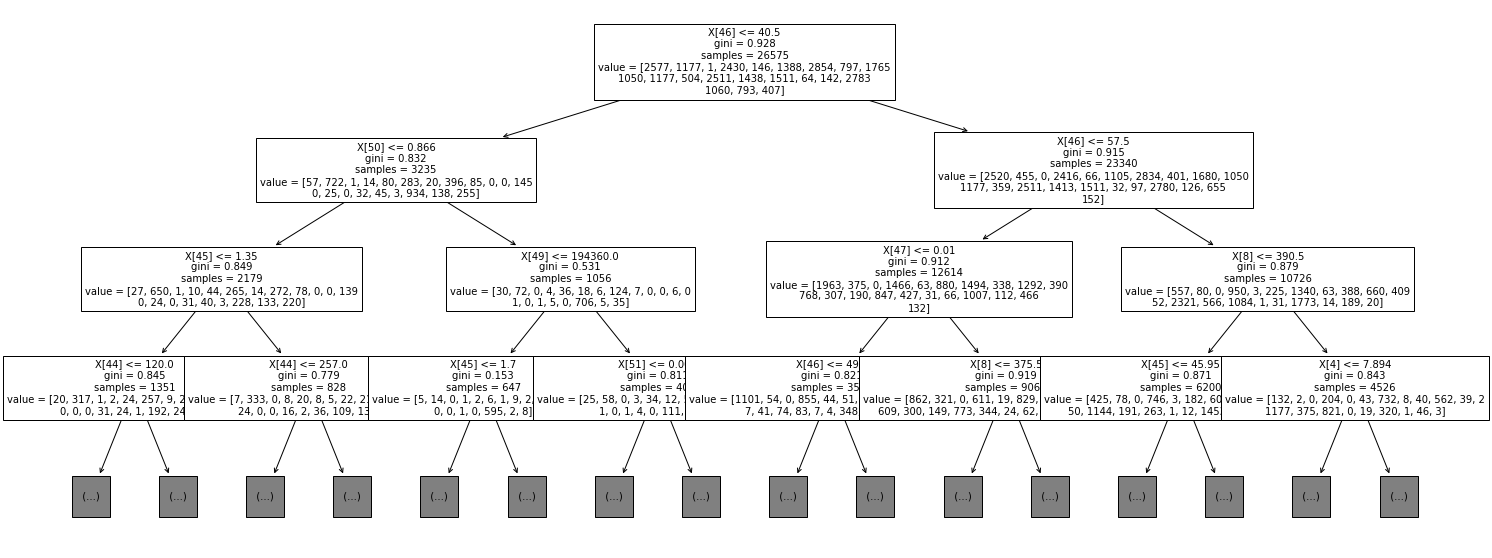

In [197]:
from sklearn.tree import plot_tree
plt.figure(figsize = (25,10))
plot_tree(decision_tree_model, max_depth = 3, fontsize=10)
plt.show()

In [198]:
df_X.columns[44:52]

Index(['a_songs', 'a_popularity', 'popularity', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness'],
      dtype='object')

In [185]:
df_X.columns[4]

'sumTfidf'

In [186]:
df_X.columns[8]

'number_of_tokens'

Esas features, al salir más arriba en el árbol, podemos interpretar que son las más importantes y que más influyen cuando el árbol toma decisiones.

In [199]:
sorted(list(df_X.columns), key = lambda column: decision_tree_model.feature_importances_[list(df_X.columns).index(column)], reverse = True)

['popularity',
 'a_songs',
 'a_popularity',
 'acousticness',
 'energy',
 'number_of_tokens',
 'duration_ms',
 'instrumentalness',
 'loudness',
 'danceability',
 'speechiness',
 'sumTfidf',
 'valence',
 'liveness',
 'VB',
 'PRP',
 'tempo',
 'compoundScore',
 'neutralScore',
 'key',
 'VBP',
 'negativeScore',
 'NNP',
 'length_of_track_name',
 'RB',
 'NN',
 'other',
 'positiveScore',
 'NNS',
 'VBG',
 'VBZ',
 'length_lyrics',
 'number_of_lines',
 'VBD',
 'VBN',
 'UH',
 'number_of_tokens_in_track_name',
 'FW',
 'PDT',
 'JJR',
 'fr',
 'mode',
 'RBR',
 'es',
 'time_signature',
 'JJS',
 'NNPS',
 'RBS',
 'ca',
 'ga',
 'de',
 'en',
 'gl',
 'is',
 'it',
 'pt',
 'rw',
 'su',
 'tl',
 'None']

Notamos que las columnas menos relevantes son las columnas de lenguajes. Cuando aplique modelos de Machine Learning más complejos seguramente cambie la forma en la que encodeo dicha variable...